In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from proj1_helpers import *
from helpers2 import *
from preprocessing import *

In [51]:
#data_folder = Path("../data/")
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [52]:
print(y)
print(np.shape(y))
print(np.shape(tX))
print(tX.dtype)
print(y.dtype)

[ 1. -1. -1. ...  1. -1. -1.]
(250000,)
(250000, 30)
float64
float64


In [53]:
feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
                 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
                 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
                 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
                 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

for i, name in enumerate(feature_names):
    print(i, feature_names[i])


0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


The training data set is composed of : 
* a y vector of length 250'000 and type float
* a tX float matrix of 250'000 rows and 30 columns

It means that our data set is composed of 250'000 different obsevations of 30 different features. In the rest of the notebook, we name the features by their index nummer. So, it means from the feature 0 from the feature  29.

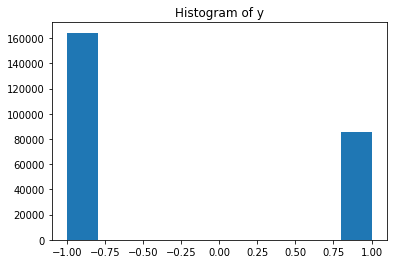

In [54]:
plt.hist(y)
plt.title('Histogram of y')
plt.show()

There is more y = -1 than y = 1 in the data, so there is more y = 'b' than y = 's'. So, we have to pay attention to normalize the data in order to compare them in the next plots.

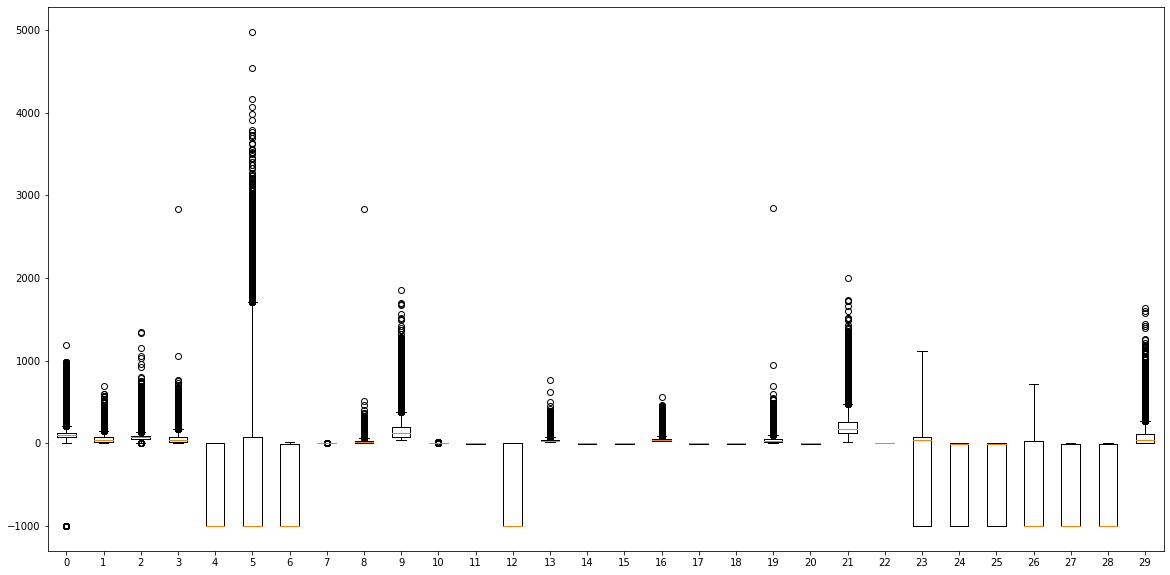

In [55]:
plt.figure(figsize=(20, 10))
ind = np.arange(30)
plt.boxplot(tX[:,], labels = ind)

plt.show()

There are many outliers depending on the feature. There are also feature that has a long interquantile range. Maybe we have to treat these feature in order to be more efficient in our futur predictions. Let's do more plots to be have a better idea :

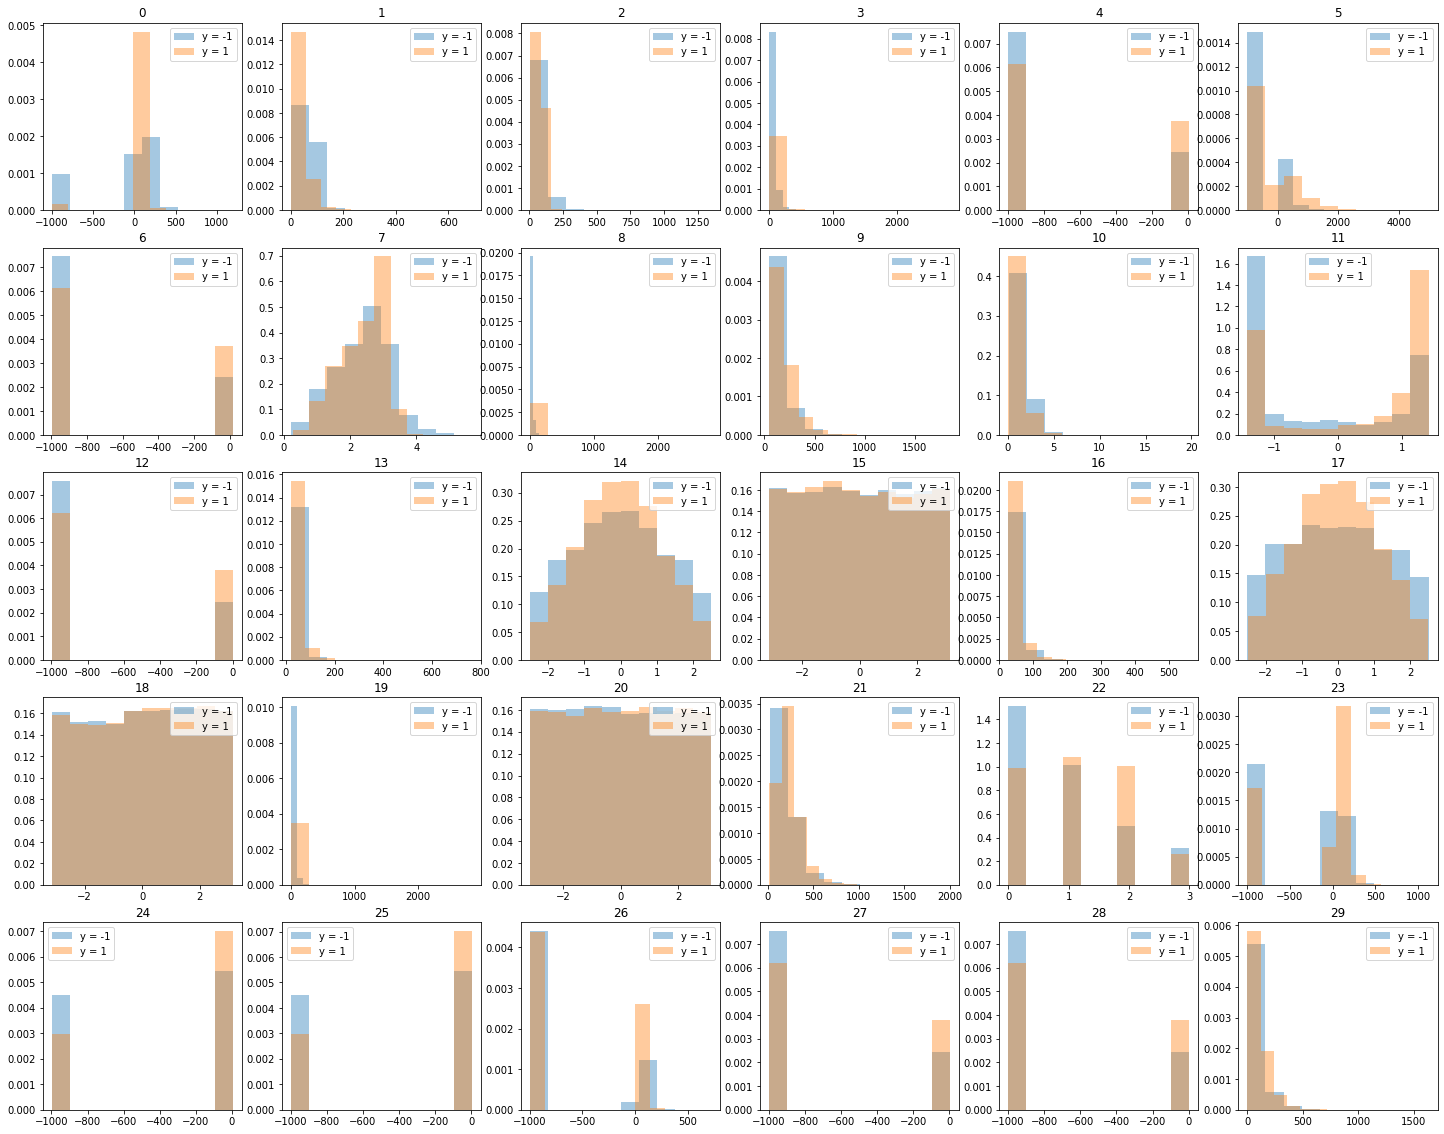

In [56]:
ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

fig, axs = plt.subplots(5, 6, figsize=(25,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
        axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
        axs[i,j].legend()
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

By plotting the histograms of the features with a color for each y, we can see that there are useless features as they have almost the same distribution for y=1 than for y = -1. We can cut feature 15, 18, 20. 


There are also features that are very inequally distributed with value that are about -1000 and values around 0 ; it can be problematic for the prediction with such a large gap between values of a single distribution. Moreover, there is not a big difference in the distribution of y=1 and y=-1. Maybe it can be useful to put off these big negative values of these features. The features in question are : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.


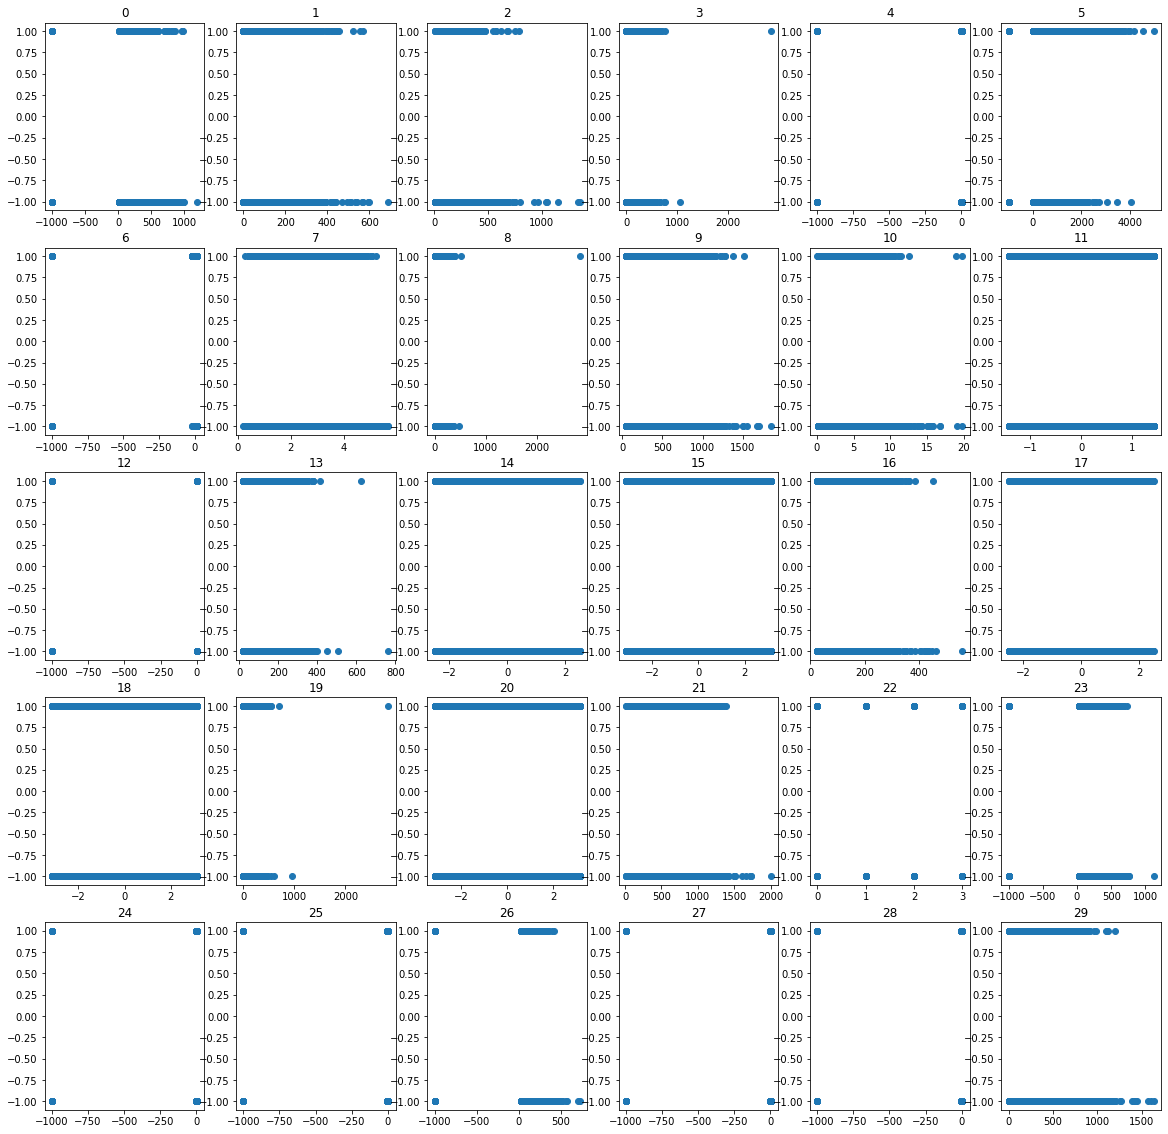

In [57]:
fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].scatter(tX[:,n], y)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

#meme constat comment faire pour se debarrasser de ces valeurs ??

These plots confirm the obsevations that we made in the previous plot ; no difference of the distribution of y for features 15, 18, 20 and very large gap in the distributions of features : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.

## Data filtering

### Outliers

In [58]:
def nb_outliers(tX, outlier) : 
    sum = 0
    nb_outliers = []
    for col in range(tX.shape[1]) :
        sum = np.where(tX[:,col] == outlier)[0].shape
        nb_outliers.append(sum)   
    print(nb_outliers)
    print(np.where(tX==outlier)[0].shape)

out = -999

print('number of -999 in the entire matrix :')
nb_outliers(tX, out)

ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

print('number of -999 in the rows where y = 1 :')
nb_outliers(tX_1, out)
print('number of -999 in the rows where y = -1 :')
nb_outliers(tX_2, out)

number of -999 in the entire matrix :
[(38114,), (0,), (0,), (0,), (177457,), (177457,), (177457,), (0,), (0,), (0,), (0,), (0,), (177457,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (99913,), (99913,), (99913,), (177457,), (177457,), (177457,), (0,)]
(1580052,)
number of -999 in the rows where y = 1 :
[(2835,), (0,), (0,), (0,), (53202,), (53202,), (53202,), (0,), (0,), (0,), (0,), (0,), (53202,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (25492,), (25492,), (25492,), (53202,), (53202,), (53202,), (0,)]
(451725,)
number of -999 in the rows where y = -1 :
[(35279,), (0,), (0,), (0,), (124255,), (124255,), (124255,), (0,), (0,), (0,), (0,), (0,), (124255,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (74421,), (74421,), (74421,), (124255,), (124255,), (124255,), (0,)]
(1128327,)


We have a problem with features  0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28. They are inequally distributed; they have a lot of -999 values and the rest is values around 0. So, here we can see how much of these -999 there are. We can see that the -999 appear only in the features that we identified with the histograms. It seems that there is a correlation between features as many features have the same number of -999. We can also see that there is more -999 in the obsevations where y=-1, so we have to take this into account when we filter the data. As there are many -999, we can't delete the rows where there is -999 because we will loose to much information.

Explication sets

In [59]:
def histograms(y, tX):
    ind_1 = np.where(y == 1)
    ind_2 = np.where(y == -1)
    tX_1 = tX[ind_1[0],:]
    tX_2 = tX[ind_2[0],:]

    fig, axs = plt.subplots(5, 6, figsize=(25,20))

    n = 0
    for i in range(5) :
        for j in range(6) :
            axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y = -1'])
            axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True, label=['y = 1'])
            axs[i,j].legend()
            axs[i,j].set_title(n)
            n = n + 1
            if n>=tX.shape[1]: break
        if n>=tX.shape[1]: break
    plt.show()

In [60]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

print('Set 1')
set1_x = outliers(set1_x, -999)
_ = outliers(set1_x, -999)

print('\nSet 2')
set2_x = outliers(set2_x, -999)
_ = outliers(set2_x, -999)

print('\nSet 3')
set3_x = outliers(set3_x, -999)
_ = outliers(set3_x, -999)

Set 1
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 2
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 3
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Set 1
[False False False False False False False False False False False False
 False False False False False False]


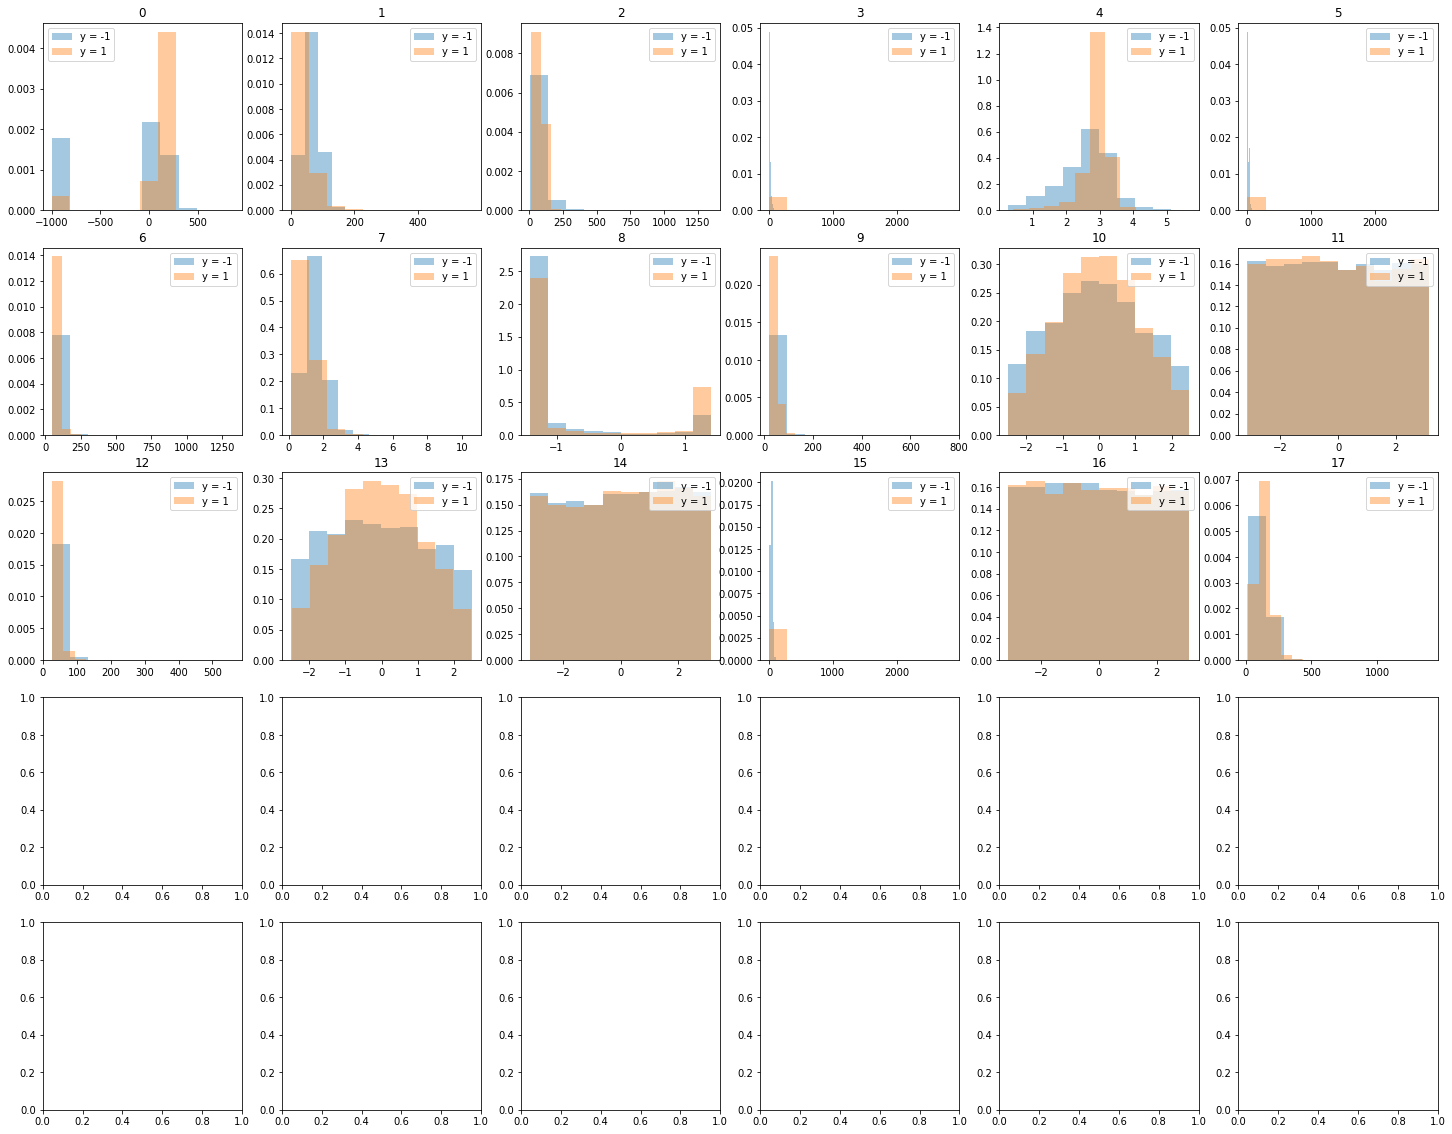


Set 2
[False False False False False False False False False False False False
 False False False False False False False False False False]


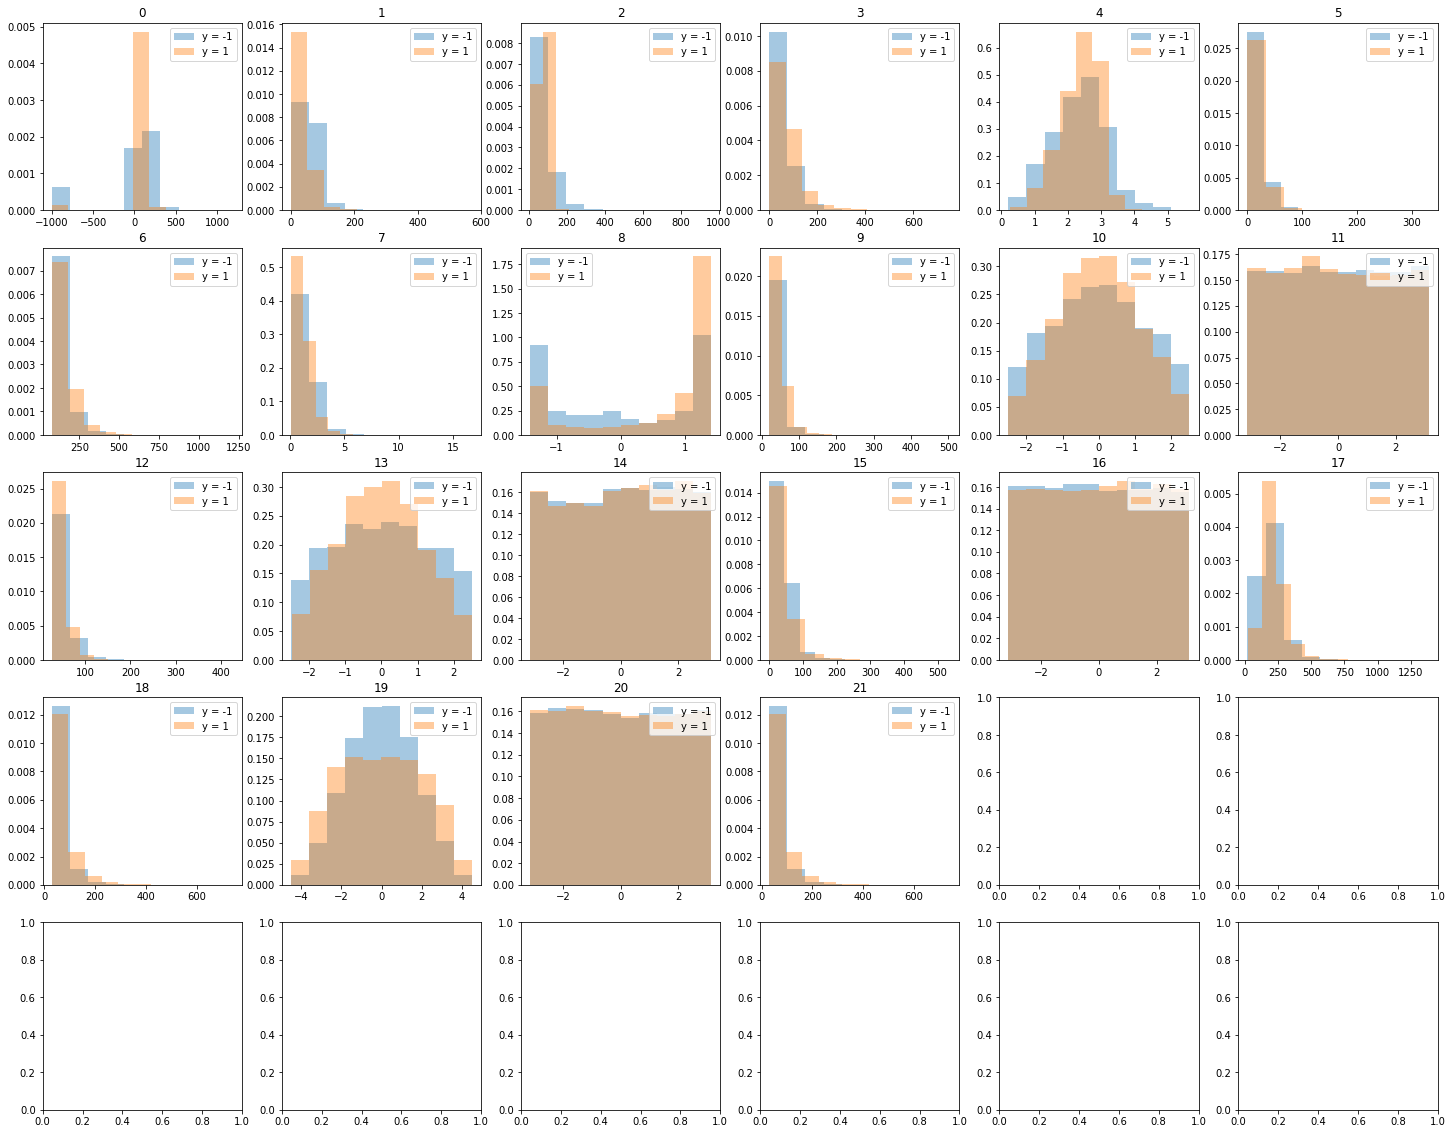


Set 3
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


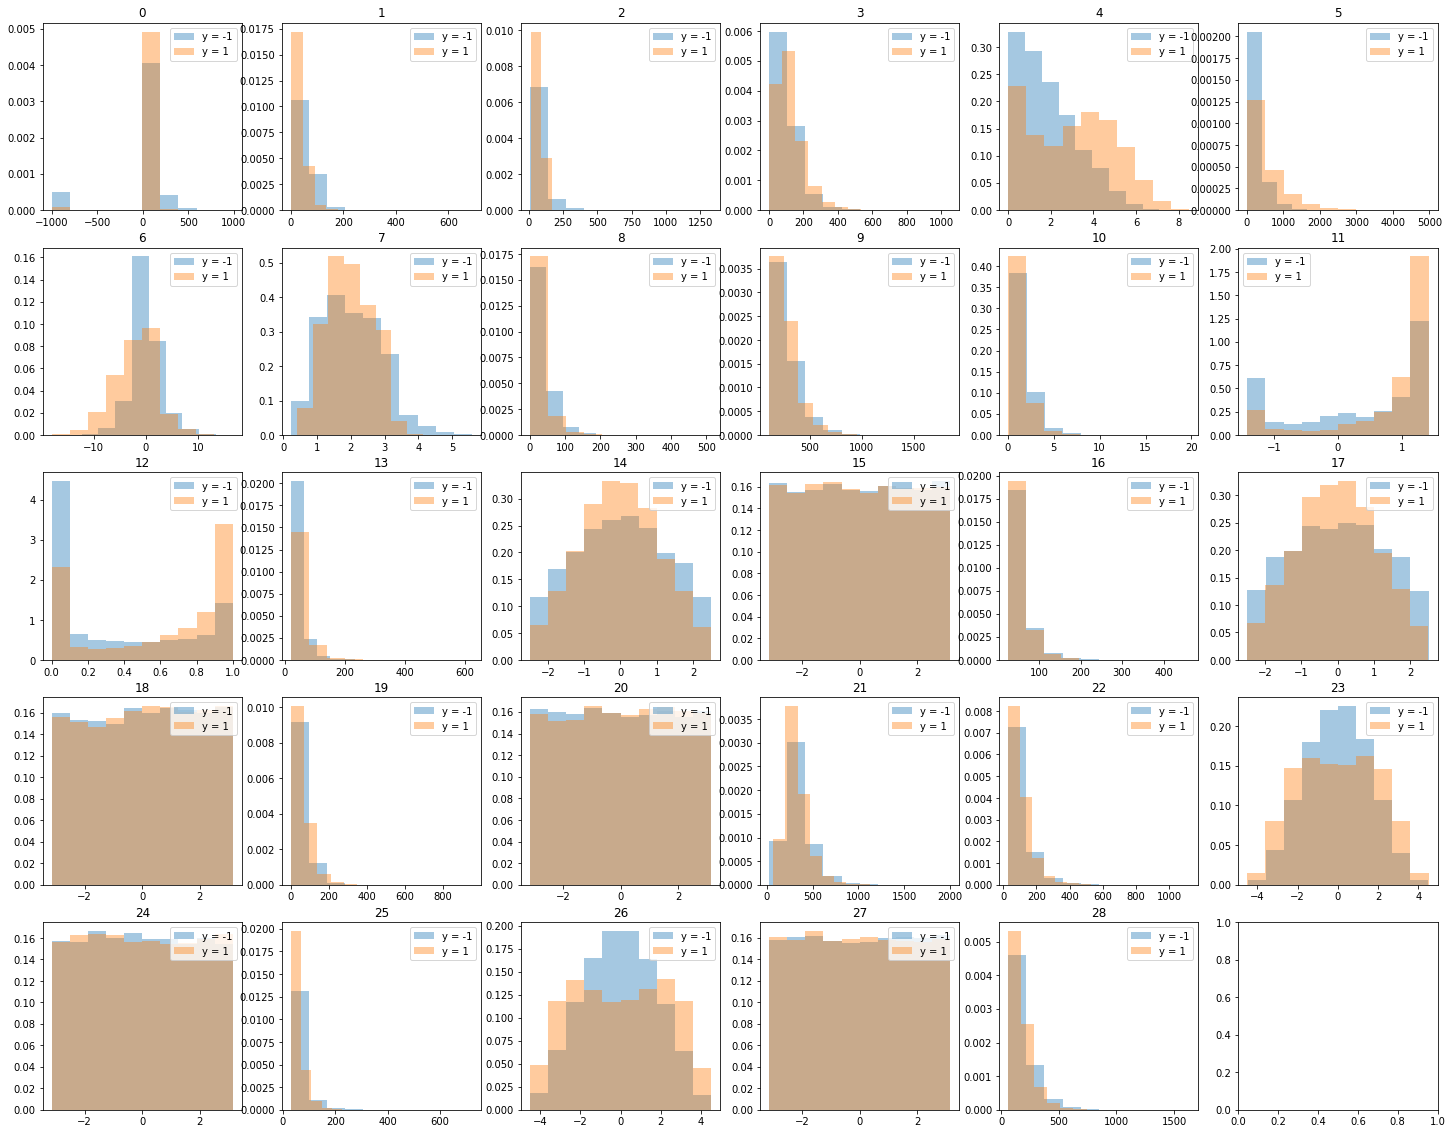

In [61]:
print('Set 1')
print(np.all(set1_x==set1_x[0], axis = 0))
histograms(set1_y, set1_x)

print('\nSet 2')
print(np.all(set2_x==set2_x[0], axis = 0))
histograms(set2_y, set2_x)

print('\nSet 3')
print(np.all(set3_x==set3_x[0], axis = 0))
histograms(set3_y, set3_x)

things to delete 

TEST FOR y=[0,1]

In order to filter the data, we want to get rif of these -999, but we can't just delete the rows. So, we have the idea to replace the -999 by the mean of the rest of values of the feature. As there is a significant difference of amount of -999 in between y=1 and y=-1 in certain features, we calculate the mean for the rows where y = 1 and y = -1 separatly.

Then, we can also standardize the data. It can be a good idea because the features are not all in the same range of values and it can create disproportionality between the importance of the features.

As we see above in the histograms, some features seem to be useless as they have a similar distribution between the y = 1 and y = -1. So, it is useful to have function that cut or keep some parameters.

In [62]:
to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]
#to_log2 = [7, 8, 10, 11, 19]

## Fonctions 

In [63]:
from implementations import *
from cross_validation import *

### Least squares

The best results for least squares regression is with the tX matrix which is standardize, filter with filtering_with_mean_bis function and whose features 15, 18, 20 are cut :

In [19]:
tX_cut = cut(tX, [15,18,20])
x_essai = std(filtering_with_mean_bis(tX_cut, y))
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(y, x_essai, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(x_essai, degree_opt)
w_ls, loss_ls = least_squares(y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_ls = degree_opt

best rmses [0.8094823719674634, 0.8367332181680027, 3.915894970097548, 7.460633536153627, 99.75861666852452, 21782.808502372467, 640181.0545578048, 18065042.09027731, 734470157.2616756, 22052422020.83767]
Cross validation finished: optimal degree 1
Least square loss rmse 0.5723030100580345


The least squares best model on the entire is degree 1 ; its accuracy is : 0.606. Let's try the same model but applied to the 3 different sets according to the PRI_jet_num parameter thanks to the separate_sets function. We sould normally improve our results : 

In [21]:
tX_cut = cut(tX, [15,18,20])

# Separation into set according to the PRI_jet_num parameter, as it is the 22th column of the entire matrix
# if we cut 3 paramaters before the 22th, PRI_jet_num is the 22-3th now
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_cut, y, ids, 22-3)

def best_filtering_ls(set_x, set_y) :
        set_x = outliers(set_x, -999)
        set_x = std(filtering_with_mean_bis(set_x, set_y))
        return set_x

print('Set 1')
set1_x_ls = best_filtering_ls(set1_x, set1_y)

print('\nSet 2')
set2_x_ls = best_filtering_ls(set2_x, set2_y)

print('\nSet 3')
set3_x_ls = best_filtering_ls(set3_x, set3_y)

Set 1
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 2
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 3
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Let's do least squares regression for each set : 

In [12]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set1_y, set1_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model 
tX_poly = build_poly(set1_x_ls, degree_opt)
w_set1_ls, loss_ls = least_squares(set1_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set1_ls = degree_opt

best rmses [0.6992124921989132, 1.9845019446411356, 49.09508655110148, 680.395540586843, 303328.3207567297, 17473312.61822008, 1257541187.5109198, 149638769519.0206, 14766571347092.793, 968707857329139.4]
Cross validation finished: optimal degree 1
Least square loss rmse 0.49359178738802756


In [13]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set2_y, set2_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(set2_x_ls, degree_opt)
w_set2_ls, loss_ls = least_squares(set2_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set2_ls = degree_opt

best rmses [0.8627394947257983, 0.8194579205690277, 0.8118322002522186, 0.8032677941638553, 0.8300628265844276, 0.892754526525992, 1.9111011828648834, 3.795161870621623, 8.013056147923317, 6.684984206978702]
Cross validation finished: optimal degree 4
Least square loss rmse 0.563695013641898


In [14]:
degrees = np.arange(1,11)
# Cross-validation on the degrees
degree_opt, _ = best_degree_selection(set3_y, set3_x_ls, degrees, k_fold=10, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
# Best degree model
tX_poly = build_poly(set3_x_ls, degree_opt)
w_set3_ls, loss_ls = least_squares(set3_y, tX_poly)
print("Least square loss rmse {loss}".format(loss=np.sqrt(loss_ls)))
degree_set3_ls = degree_opt

best rmses [0.8494265790401101, 0.8048402897267272, 0.7838667573027494, 0.7804477199035814, 0.7723920603771754, 1.1329656722635941, 1.1764287361183663, 3.804494848573087, 17.168085104218402, 52.06761713224065]
Cross validation finished: optimal degree 5
Least square loss rmse 0.5401761404390758


The least square best model (standardize + filter_with_mean_bis + cut 15,18,20) with separate_sets is :
* set 1 : degree 1
* set 2 : degree 4
* set 3 : degree 5

We have a better accuracy : 0.683

### Ridge regression 

The best results for Ridge regression is with tX that is only filtered by filtering_with_mean_bis function : 

In [30]:
degrees = np.arange(1,8)
x_essai = filtering_with_mean_bis(tX, y)
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
degree_rr = degree_opt

best rmses [0.8095450909357379, 0.844544477269849, 2.2534289074606, 0.9046219752885352, 344.6792667724601, 25071.139924639538, 1438117.9697410704]
Cross validation finished: optimal lambda 0.0001 and degree 1
Ridge regression loss 0.3275363710713481


Let's look if we can improve the results with the separation of tX into sets according to the feature 22 (PRI_jet_num) : 

In [20]:
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX, y, ids)

def best_filtering_rr(set_x, set_y) :
        set_x = outliers(set_x, -999)
        set_x = filtering_with_mean_bis(set_x, set_y)
        return set_x
    

print('Set 1')
set1_x_rr = best_filtering_rr(set1_x, set1_y)

print('\nSet 2')
set2_x_rr = best_filtering_rr(set2_x, set2_y)

print('\nSet 3')
set3_x_rr = best_filtering_rr(set3_x, set3_y)

Set 1
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 2
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 3
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Ridge regression according to the different sets : 

In [22]:
degrees = np.arange(1,8)
x_essai = set1_x_rr
y = set1_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set1, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set1 = lambda_opt
degree_rr_set1 = degree_opt

best rmses [0.6992441526016957, 2.6438327297625164, 55.80989893325343, 63.684666434180755, 419376.3821326866, 13368684.219238853, 1250756574.718208]
Cross validation finished: optimal lambda 0.0001 and degree 1
Ridge regression loss 0.24363595402634777


In [23]:
degrees = np.arange(1,8)
x_essai = set2_x_rr
y = set2_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set2, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set2 = lambda_opt
degree_rr_set2 = degree_opt

best rmses [0.862899048310838, 0.8169222621606087, 0.8101900728020305, 0.8002962438481538, 0.8261304186737602, 1.2120544270432492, 1.7233468351025003]
Cross validation finished: optimal lambda 0.0002592943797404667 and degree 4
Ridge regression loss 0.31512983201516304


In [26]:
degrees = np.arange(1,8)
x_essai = set3_x_rr
y = set3_y
# Cross-validation on the degrees and the lambdas
degree_opt, lambda_opt = best_degree_selection(y, x_essai, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
# Best degree and lambda model
x_essai = build_poly(x_essai, degree_opt)
w_rr_set3, loss_rr = ridge_regression(y, x_essai, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
lambda_rr_set3 = lambda_opt
degree_rr_set3 = degree_opt

best rmses [0.8495901136277599, 0.8051128492381056, 0.7850629220809948, 0.7798421457960129, 0.8176384928243913, 0.9426713170684411, 2.8857314167790853]
Cross validation finished: optimal lambda 0.0002592943797404667 and degree 4
Ridge regression loss 0.29715852129995324


The least square best model (filter_with_mean_bis) with separate_sets is :
* set 1 : degree 1 and lambda = 0.0001
* set 2 : degree 4 and lambda = 0.0002592943797404667
* set 3 : degree 4 and lambda = 0.0002592943797404667

We have better results with the matrix that is separated in sets, so let's do a submission with this method. We have 0.801 of accuracy.

### Gradient descent

We process the data to get better results 

In [14]:
k_fold = 4
max_iters = 500
gammas = np.arange(0, 0.5, 0.01)
tX_log = log_distribution(tX, to_log)

set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = outliers(set1_x, -999)
set1_x = filtering_with_mean_bis(set1_x, set1_y)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)

set2_x = outliers(set2_x, -999)
set2_x = filtering_with_mean_bis(set2_x, set2_y)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = outliers(set3_x, -999)
set3_x = filtering_with_mean_bis(set3_x, set3_y)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)
print('')
print("Preprocessing for gradient descent done!")

outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Preprocessing for gradient descent done!


In the next cells, we perform a 4-fold cross validation for the gamma parameter for gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt1 = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=2)
w_gd1, loss_gd1 = least_squares_GD(set1_y, set1_x, gamma_opt1, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt1))
print("Gradient descent regression loss {loss}".format(loss=loss_gd1))

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.5
Gradient Descent(2/49): loss=0.5
Gradient Descent(3/49): loss=0.5
Gradient Descent(4/49): loss=0.5
Gradient Descent(5/49): loss=0.5
Gradient Descent(6/49): loss=0.5
Gradient Descent(7/49): loss=0.5
Gradient Descent(8/49): loss=0.5
Gradient Descent(9/49): loss=0.5
Gradient Descent(10/49): loss=0.5
Gradient Descent(11/49): loss=0.5
Gradient Descent(12/49): loss=0.5
Gradient Descent(13/49): loss=0.5
Gradient Descent(14/49): loss=0.5
Gradient Descent(15/49): loss=0.5
Gradient Descent(16/49): loss=0.5
Gradient Descent(17/49): loss=0.5
Gradient Descent(18/49): loss=0.5
Gradient Descent(19/49): loss=0.5
Gradient Descent(20/49): loss=0.5
Gradient Descent(21/49): loss=0.5
Gradient Descent(22/49): loss=0.5
Gradient Descent(23/49): loss=0.5
Gradient Descent(24/49): loss=0.5
Gradient Descent(25/49): loss=0.5
Gradient Descent(26/49): loss=0.5
Gradient Descent(27/49): loss=0.5
Gradient Descent(28/49): loss=0.5
Gradient Descent(29/49):

In [ ]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt2 = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=2)
w_gd2, loss_gd2 = least_squares_GD(set2_y, set2_x, gamma_opt2, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Gradient descent regression loss {loss}".format(loss=loss_gd2))

In [ ]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt3 = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=2)
w_gd3, loss_gd3 = least_squares_GD(set3_y, set3_x, gamma_opt3, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Gradient descent regression loss {loss}".format(loss=loss_gd3))

### Stochastic gradient descent

In [45]:
k_fold = 4
max_iters = 500
gammas = np.arange(0, 0.5, 0.01)
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = outliers(set1_x, -999)
set1_x = filtering_with_mean_bis(set1_x, set1_y)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)

set2_x = outliers(set2_x, -999)
set2_x = filtering_with_mean_bis(set2_x, set2_y)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = outliers(set3_x, -999)
set3_x = filtering_with_mean_bis(set3_x, set3_y)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)
print('')
print("Preprocessing for stochastic gradient descent done!")

outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Preprocessing for stochastic gradient descent done!


In the next cells, we perform a 4-fold cross validation for the gamma parameter for stochastic gradient descent method for each set. Then we we perform a stochastic gradient descent with the optimal gamma found. For the cross validation we use 50 iterations and for the final descent 500 iterations as we want a more precise final result. 

In [ ]:
gamma_opt_sgd1 = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=3)
w_sgd1, loss_sgd1 = least_squares_SGD(set1_y, set1_x, gamma_opt_sgd1, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt_sgd1))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd1))

In [ ]:
gamma_opt2 = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=3)
w_sgd2, loss_sgd2 = least_squares_SGD(set2_y, set2_x, gamma_opt2, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt2))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd2))

In [ ]:
gamma_opt3 = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=3)
w_sgd3, loss_sgd3 = least_squares_SGD(set3_y, set3_x, gamma_opt3, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt3))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_sgd3))

### Logistic regression

In [16]:
from implementations import *
from cross_validation import *

In [87]:
y[y==-1]=0 # transform y=-1 to 0
k_fold = 4
max_iters = 50
gammas = np.arange(0, 0.5, 0.01) 
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = outliers(set1_x, -999)
set1_x = filtering_with_mean_bis(set1_x, set1_y, lr=1)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)
#set1_x = scaling(set1_x)

set2_x = outliers(set2_x, -999)
set2_x = filtering_with_mean_bis(set2_x, set2_y, lr=1)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = outliers(set3_x, -999)
set3_x = filtering_with_mean_bis(set3_x, set3_y, lr=1)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)

print('')
print("Preprocessing for logistic regression done!")

outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Preprocessing for logistic regression done!


In [97]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt = cross_validation(set1_y, set1_x_lr, k_fold, gammas, fonction=4)
w_lr1, loss_lr = logistic_regression(set1_y, set1_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=51940.29082807905
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=51940.29082807905
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=51940.29082807904
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=51940.29082807904
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=51940.29082807905
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=51940.29082807905
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=51940.29082807904
t [[0.]

In [98]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt = cross_validation(set2_y, set2_x, k_fold, gammas, fonction=4)
w_lr2, loss_lr = logistic_regression(set2_y,set2_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
loss=40312.053727005376
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
t [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Current iteration=0, loss=40312.053727005376


In [ ]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=4)
w_lr3, loss_lr = logistic_regression(set3_y, set3_x, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("logistic regression loss {loss}".format(loss=loss_lr))

### Regularized logistic regression

In [1]:
k_fold = 4
max_iters = 5
gammas = np.arange(0, 0.5, 0.01)
lambdas = np.logspace(-4, 0, 10)
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

set1_x = outliers(set1_x, -999)
set1_x = filtering_with_mean_bis(set1_x, set1_y, lr=1)
#set1_x = filtering_with_mean(set1_x)
set1_x = std(set1_x)
#set1_x = scaling(set1_x)

set2_x = outliers(set2_x, -999)
set2_x = filtering_with_mean_bis(set2_x, set2_y, lr=1)
#set2_x = filtering_with_mean(set2_x)
set2_x = std(set2_x)

set3_x = outliers(set3_x, -999)
set3_x = filtering_with_mean_bis(set3_x, set3_y, lr=1)
#set3_x = filtering_with_mean(set3_x)
set3_x = std(set3_x)

print('')
print("Preprocessing for regularized logistic regression done!")

NameError: name 'np' is not defined

In [ ]:
initial_w = np.zeros(set1_x.shape[1])
gamma_opt, lambda_opt = best_param_selection(set1_y, set1_x, k_fold, gammas, lambdas, fonction=5)
w_rlr1, loss_rlr = reg_logistic_regression(set1_y, set1_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))

Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.290828079065
loss=51940.290828079065
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.290828079065
loss=51940.290828079065
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.290828079065
loss=51940.290828079065
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807906
loss=51940.29082807906
Current iteration=0, loss=51940.29082807904
loss=51940.29082807904
Current iteration=0, loss=51940.290828079065
loss=51940.

/home/MachineLearning/FinalCopy2/scripts/cross_validation.py:61: RuntimeWarning: invalid value encountered in sqrt
  loss_tr = np.sqrt(2*loss_tr)


Current iteration=0, loss=51940.29082807904
Current iteration=2, loss=36314.41022877964
Current iteration=4, loss=22445.22488376712
Current iteration=6, loss=9929.567244548745
Current iteration=8, loss=-1539.3846690476953
loss=-12186.5886644606
Current iteration=0, loss=51940.290828079065
Current iteration=2, loss=36440.79967624978
Current iteration=4, loss=22687.97229738101
Current iteration=6, loss=10280.06120033935
Current iteration=8, loss=-1088.197289952732
loss=-11640.369740404902
Current iteration=0, loss=51940.29082807906
Current iteration=2, loss=36401.920427220495
Current iteration=4, loss=22610.820501436498
Current iteration=6, loss=10166.535208411922
Current iteration=8, loss=-1235.8923619109762
loss=-11820.117502021414
Current iteration=0, loss=51940.29082807906
Current iteration=2, loss=36318.154482436774
Current iteration=4, loss=22450.13253809374
Current iteration=6, loss=9935.037415832729
Current iteration=8, loss=-1533.0134580881281
loss=-12178.705112575219
Current it

In [ ]:
initial_w = np.zeros(set2_x.shape[1])
gamma_opt = cross_validation(set2_y, set2_x, k_fold, gammas, lambdas, fonction=5)
w_rlr2, loss_rlr = reg_logistic_regression(set2_y, set2_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))
# Best gamma and lambda model
lambda_rlr_set2 = lambda_opt
gamma_rlr_set2 = degree_opt

In [ ]:
initial_w = np.zeros(set3_x.shape[1])
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, lambdas, fonction=5)
w_rlr3, loss_rlr = reg_logistic_regression(set3_y, set3_x, lambda_opt, initial_w, max_iters, gamma_opt)
print("Cross validation finished: optimal lambda {l} and gamma {g}".format(l=lambda_opt, g=gamma_opt))
print("regularized logistic regression loss {loss}".format(loss=loss_rlr))
# Best gamma and lambda model
lambda_rlr_set3 = lambda_opt
gamma_rlr_set3 = degree_opt

## Generate predictions and save ouput in csv format for submission:

In [106]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

#### Least squares submissions

In [ ]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
OUTPUT_PATH = '../data/pred_ls.csv' 
tX_test_ls = cut(std(filtering_with_mean(tX_test)),[15,18,20])
tX_test_ls = build_poly(tX_test_ls, degree_ls)
y_pred = predict_labels(w_ls, tX_test_ls)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH

In [ ]:
OUTPUT_PATH = '../data/pred_set_ls.csv' 
DATA_TEST_PATH = '../data/test.csv'
y_test , tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test = cut(tX_test, [15,18,20])

set1_x, _, set1_ids, set2_x, _, set2_ids, set3_x, _, set3_ids = separate_sets(tX_test, y_test, ids_test, 22-3)

def filtering_test_ls (set_x, degree_rr):
    print(set_x.shape)
    set_x = outliers(set_x, -999)
    print(set_x.shape)
    set_x = std(filtering_with_mean(set_x))
    set_x = build_poly(set_x, degree_rr)
    return set_x


set1_x = filtering_test_ls(set1_x, degree_set1_ls)
set2_x = filtering_test_ls(set2_x, degree_set2_ls)
set3_x = filtering_test_ls(set3_x, degree_set3_ls)

y_pred1 = predict_labels(w_set1_ls, set1_x)
y_pred2 = predict_labels(w_set2_ls, set2_x)
y_pred3 = predict_labels(w_set3_ls, set3_x)

y_pred_ls, ids_ls = concatenate_sets(y_pred1, set1_ids, y_pred2, set2_ids, y_pred3, set3_ids)
create_csv_submission(ids_ls, y_pred_ls, OUTPUT_PATH)

#### Ridge regression submissions

In [ ]:
OUTPUT_PATH = '../data/pred_set_rr.csv' 
DATA_TEST_PATH = '../data/test.csv'
y_test , tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

set1_x, _, set1_ids, set2_x, _, set2_ids, set3_x, _, set3_ids = separate_sets(tX_test, y_test, ids_test)

def filtering_test_rr (set_x, degree_rr):
    set_x = outliers(set_x, -999)
    set_x = build_poly(set_x, degree_rr)
    return set_x

set1_x = filtering_test_rr(set1_x, degree_rr_set1)
set2_x = filtering_test_rr(set2_x, degree_rr_set2)
set3_x = filtering_test_rr(set3_x, degree_rr_set3)
y_pred1 = predict_labels(w_rr_set1, set1_x)
y_pred2 = predict_labels(w_rr_set2, set2_x)
y_pred3 = predict_labels(w_rr_set3, set3_x)

y_pred_rr, ids_rr = concatenate_sets(y_pred1, set1_ids, y_pred2, set2_ids, y_pred3, set3_ids)
create_csv_submission(ids_rr, y_pred_rr, OUTPUT_PATH)

#### Gradient descent submissions

In [ ]:
tX_test_log = log_distribution(tX_test, to_log)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX_test_log, _, ids_test)

test_set1_x = outliers(test_set1_x, -999)
test_set1_x = filtering_with_mean(test_set1_x)
test_set1_x = std(test_set1_x)

test_set2_x = outliers(test_set2_x, -999)
test_set2_x = filtering_with_mean(test_set2_x)
test_set2_x = std(test_set2_x)

test_set3_x = outliers(test_set3_x, -999)
test_set3_x = filtering_with_mean(test_set3_x)
test_set3_x = std(test_set3_x)

In [ ]:
OUTPUT_PATH = '../data/pred_gd.csv' # TODO: fill in desired name of output file for submission
y_pred1 = predict_labels(w_gd1, test_set1_x)
y_pred2 = predict_labels(w_gd2, test_set2_x)
y_pred3 = predict_labels(w_gd3, test_set3_x)
y_pred = np.concatenate((y_pred1, y_pred2, y_pred3), axis=0)
ids_test = np.concatenate((test_set1_ids, test_set2_ids, test_set3_ids), axis=0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Stochastic gradient descent submissions

In [ ]:
tX_test_log = log_distribution(tX_test, to_log)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX_test_log, _, ids_test)

test_set1_x = outliers(test_set1_x, -999)
test_set1_x = filtering_with_mean(test_set1_x)
test_set1_x = std(test_set1_x)

test_set2_x = outliers(test_set2_x, -999)
test_set2_x = filtering_with_mean(test_set2_x)
test_set2_x = std(test_set2_x)

test_set3_x = outliers(test_set3_x, -999)
test_set3_x = filtering_with_mean(test_set3_x)
test_set3_x = std(test_set3_x)

In [ ]:
OUTPUT_PATH = '../data/pred_gd.csv' # TODO: fill in desired name of output file for submission
y_pred1 = predict_labels(w_gd1, test_set1_x)
y_pred2 = predict_labels(w_gd2, test_set2_x)
y_pred3 = predict_labels(w_gd3, test_set3_x)
y_pred = np.concatenate((y_pred1, y_pred2, y_pred3), axis=0)
ids_test = np.concatenate((test_set1_ids, test_set2_ids, test_set3_ids), axis=0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Logistic regressions submissions

In [107]:
tX_test_log = log_distribution(tX_test, to_log)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX_test_log, _, ids_test)

test_set1_x = outliers(test_set1_x, -999)
test_set1_x = np.c_[np.ones((test_set1_x .shape[0], 1)), test_set1_x ]
test_set1_x = filtering_with_mean(test_set1_x)
test_set1_x = std(test_set1_x)

test_set2_x = np.c_[np.ones((test_set2_x .shape[0], 1)), test_set2_x ]
test_set2_x = outliers(test_set2_x, -999)
test_set2_x = filtering_with_mean(test_set2_x)
test_set2_x = std(test_set2_x)

test_set3_x = np.c_[np.ones((test_set3_x .shape[0], 1)), test_set3_x ]
test_set3_x = outliers(test_set3_x, -999)
test_set3_x = filtering_with_mean(test_set3_x)
test_set3_x = std(test_set3_x)

outliers ratio for each feature [0.26054480387588036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.0, 0.09834148900979822, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.0, 0.060335344108509326, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [113]:
OUTPUT_PATH = '../data/pred_lr.csv' # TODO: fill in desired name of output file for submission
y_pred1 = predict_labels(w_lr1, test_set1_x)
y_pred2 = predict_labels(w_lr2, test_set2_x)
y_pred3 = predict_labels(w_lr3, test_set3_x)
y_pred = np.concatenate((y_pred1, y_pred2, y_pred3), axis=0)
ids_test = np.concatenate((test_set1_ids, test_set2_ids, test_set3_ids), axis=0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Regularized logistic regressions submissions

In [ ]:
tX_test_log = log_distribution(tX_test, to_log)
test_set1_x, _, test_set1_ids, test_set2_x, _, test_set2_ids, test_set3_x, _, test_set3_ids = separate_sets(tX_test_log, _, ids_test)

test_set1_x = outliers(test_set1_x, -999)
test_set1_x = np.c_[np.ones((test_set1_x .shape[0], 1)), test_set1_x ]
test_set1_x = filtering_with_mean(test_set1_x) # BIS ????
test_set1_x = std(test_set1_x)

test_set2_x = np.c_[np.ones((test_set2_x .shape[0], 1)), test_set2_x ]
test_set2_x = outliers(test_set2_x, -999)
test_set2_x = filtering_with_mean(test_set2_x)
test_set2_x = std(test_set2_x)

test_set3_x = np.c_[np.ones((test_set3_x .shape[0], 1)), test_set3_x ]
test_set3_x = outliers(test_set3_x, -999)
test_set3_x = filtering_with_mean(test_set3_x)
test_set3_x = std(test_set3_x)

In [113]:
OUTPUT_PATH = '../data/pred_rlr.csv' # TODO: fill in desired name of output file for submission
y_pred1 = predict_labels(w_rlr1, test_set1_x)
y_pred2 = predict_labels(w_rlr2, test_set2_x)
y_pred3 = predict_labels(w_rlr3, test_set3_x)
y_pred = np.concatenate((y_pred1, y_pred2, y_pred3), axis=0)
ids_test = np.concatenate((test_set1_ids, test_set2_ids, test_set3_ids), axis=0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)